In [ ]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [ ]:
#데이터 불러오기
fashion=pd.read_csv('/content/drive/MyDrive/data/fashion-mnist.csv') #경로수정: 완료
fashion

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [ ]:
y_label = fashion.loc[:,'label']
X_features = fashion.drop(['label'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, train_size=0.8, test_size=0.2, stratify=y_label, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(48000, 784) (12000, 784) (48000,) (12000,)



- 어떻게 생긴 데이터셋인지 확인해보기

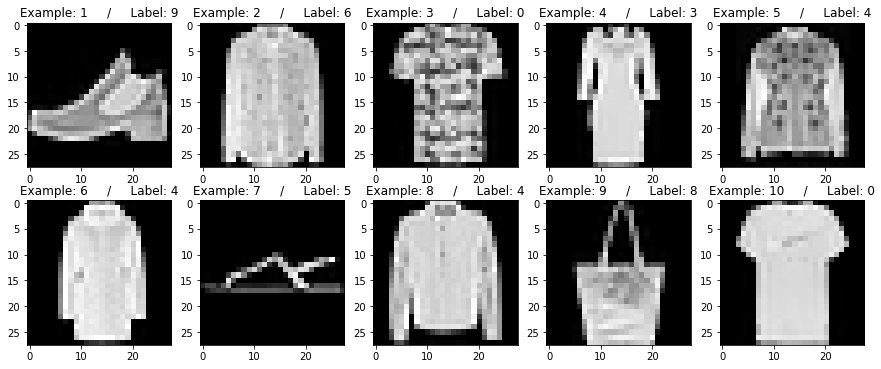

In [ ]:
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_label.loc[i]
  image = X_features.loc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


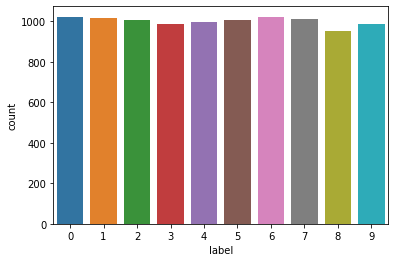

In [ ]:
#train dataset으로 10000개만 사용
X_train=X_train.iloc[:10000,:]
y_train=y_train[:10000]
sns.countplot(y_train) #y라벨이 균등하게 분포하는지 확인
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


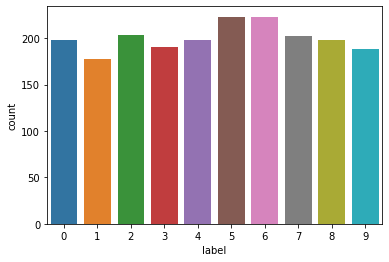

In [ ]:
#test dataset으로 2000개만 사용
X_test=X_test.iloc[:2000,:]
y_test=y_test[:2000]
sns.countplot(y_test)
plt.show()

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 784) (10000,) (2000, 784) (2000,)


# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=784) #785차원의 잠재변수
X_train_PCA=pca.fit_transform(X_train)
X_train_PCA.shape

(10000, 784)

In [ ]:
pca.explained_variance_ratio_[:10]

array([0.29126802, 0.17911953, 0.05994053, 0.04954732, 0.03726072,
       0.03562977, 0.02326399, 0.01850517, 0.01373678, 0.01296689])

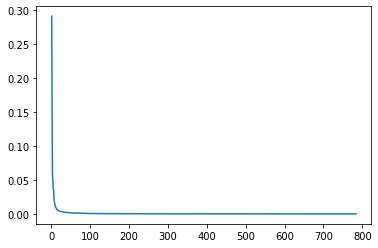

In [ ]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.show()

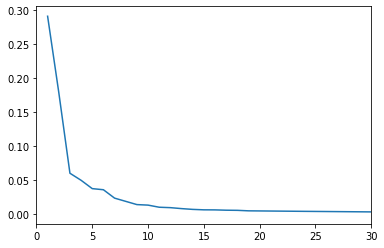

In [ ]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.xlim(0,30)
plt.show()

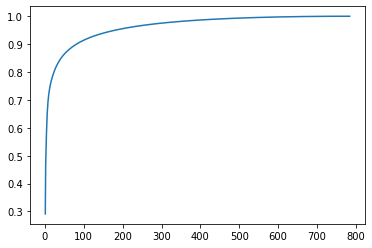

In [ ]:
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

In [ ]:
for i in [10,20,30,40,50,100,784]:
  explained=np.sum(pca.explained_variance_ratio_[:i])
  print(i,'개의 잠재변수가 설명하는 분산은 전체 데이터의 {:.2f}%'.format(explained*100))

10 개의 잠재변수가 설명하는 분산은 전체 데이터의 72.12%
20 개의 잠재변수가 설명하는 분산은 전체 데이터의 78.65%
30 개의 잠재변수가 설명하는 분산은 전체 데이터의 82.24%
40 개의 잠재변수가 설명하는 분산은 전체 데이터의 84.66%
50 개의 잠재변수가 설명하는 분산은 전체 데이터의 86.44%
100 개의 잠재변수가 설명하는 분산은 전체 데이터의 91.42%
784 개의 잠재변수가 설명하는 분산은 전체 데이터의 100.00%


In [ ]:
cumulative=np.array(cumulative)
np.where(cumulative>0.8)[0][0] #분산의 80% 이상을 설명하는 최소 개수는 23개

23

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


In [ ]:
pca=PCA(n_components=23)
X_train_PCA=pca.fit_transform(X_train) #train은 fit + transform
X_test_PCA=pca.transform(X_test)       #test는 transform
print('Original space of X_train:',X_train.shape)
print('After PCA at X_train:',X_train_PCA.shape)
print('Original space of X_test:',X_test.shape)
print('After PCA at X_test:',X_test_PCA.shape)

Original space of X_train: (10000, 784)
After PCA at X_train: (10000, 23)
Original space of X_test: (2000, 784)
After PCA at X_test: (2000, 23)


1. RandomForest

In [ ]:
#차원축소 이전(784차원)
start=time.time()
rf_original=RandomForestClassifier()
rf_original.fit(X_train,y_train)
print('train accuracy:',accuracy_score(y_train, rf_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, rf_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.841
16.8006sec


In [ ]:
#차원축소 이후(23차원)
start=time.time()
rf_pca=RandomForestClassifier()
rf_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, rf_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, rf_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec') 
#학습 속도가 17초 -> 5초 정도로 크게 단축되었음을 확인, 다만 accuracy는 미세하게 하락
#그래도 성능은 크게 차이나지 않으니 pca가 훨씬 효과가 있다고 볼 수 o

train accuracy: 1.0
test accuracy: 0.8185
4.8873sec


2. LightGBM

In [ ]:
#차원축소 이전
from lightgbm import LGBMClassifier
start=time.time()
lgbm_original = LGBMClassifier()
lgbm_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, lgbm_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, lgbm_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8565
184.8236sec


In [ ]:
#차원축소 이후
start=time.time()
lgbm_pca = LGBMClassifier()
lgbm_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, lgbm_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, lgbm_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')
#학습 속도가 185초 -> 10초 정도로 매우매우 단축되었음을 확인, 다만 accuracy는 미세하게 하락
#그래도 성능은 크게 차이나지 않으니 pca가 훨씬 효과가 있다고 볼 수 o

train accuracy: 0.9964
test accuracy: 0.8255
9.7493sec


# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

1. PCA

In [ ]:
start=time.time()
pca=PCA(n_components=2)
X_train_PCA=pca.fit_transform(X_train) 
print(f'{time.time()-start:.4f}sec')

1.2444sec


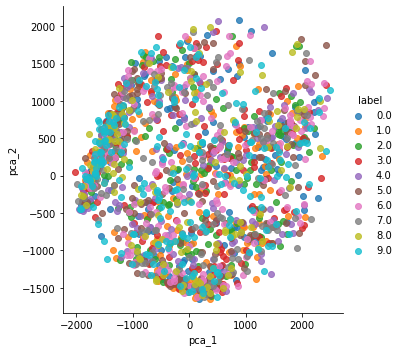

In [ ]:
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

pca는 영 아닌 것 같다. 군집이 모여 있지 않고 마치 현대 예술의 한 작품처럼 나왔다

2. LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start=time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train) #차원축소 과정에 y라벨값을 입력해줌
print(f'{time.time()-start:.4f}sec')

3.5169sec


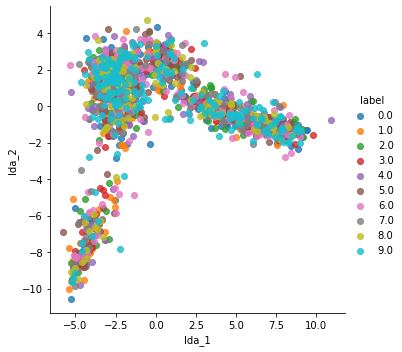

In [ ]:
#X_train_lda=pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda=pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

부메랑같다,, KPCA로 재도전

3. KPCA

In [ ]:
#방사형 커널 사용
from sklearn.decomposition import KernelPCA
start=time.time()
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)

X_train_rbf_pca=rbf_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

63.4343sec


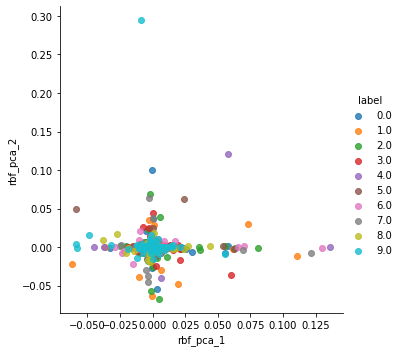

In [ ]:
X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca=pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

,,,,다른 감마를 사용해보자

In [ ]:
from sklearn.decomposition import KernelPCA
start=time.time()
rbf_pca2 = KernelPCA(n_components = 2, kernel="rbf", gamma=0.1, fit_inverse_transform=True)

X_train_rbf_pca2=rbf_pca2.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

61.8169sec


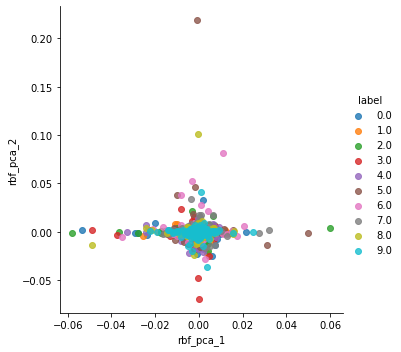

In [ ]:
X_train_rbf_pca2=pd.DataFrame(X_train_rbf_pca2).loc[:,0:1]
X_train_rbf_pca2=pd.concat((X_train_rbf_pca2, y_train), axis=1) 
X_train_rbf_pca2.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca2,hue='label',fit_reg=False)
plt.show()

다른 커널 함수를 사용해보자,,,

In [ ]:
#시그모이드 커널 사용
start=time.time()
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=15, coef0=1, fit_inverse_transform=True) 
X_train_sig_pca=sig_pca.fit_transform(X_train)
#X_test_rbf_pca=sig_pca.fit_transform(X_test)
print(f'{time.time()-start:.4f}sec')

63.5646sec


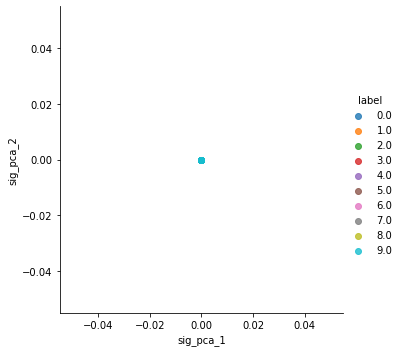

In [ ]:
X_train_sig_pca=pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca=pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']
sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

이게 뭘까

4. IsoMap

In [ ]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=5,n_components=2,n_jobs=4)         
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

91.4061sec


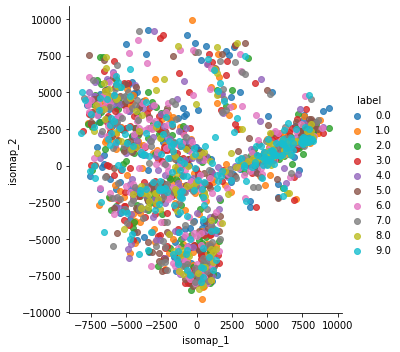

In [ ]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

> ->LDA가 그나마 잘 시각화한 것 같다. 전반적으로 성능이 좋지 않다.

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

하나의 라벨을 언급하기 어려울 정도로 다같이 분류가 되지 않는다. 차원을 극도로 낮게 설정했기에 데이터 손실이 많이 일어난 것으로 추정된다. 그래도 하나 추정을 해보자면 Label 5에 해당되는 신발의 모양이 가장 복잡하기 때문에 가장 분류가 어려울 것 같다.

수고하셨습니다~